# 文字預測股票漲跌專案

***根據網路上各類新聞文章預測某一公司股價的漲跌***


台大經研所 羅偉駿

![LinkedIn](https://img.shields.io/badge/linkedin-%230077B5.svg?style=for-the-badge&logo=linkedin&logoColor=white)
![GitHub](https://img.shields.io/badge/github-%23121011.svg?style=for-the-badge&logo=github&logoColor=white)
![Medium](https://img.shields.io/badge/Medium-12100E?style=for-the-badge&logo=medium&logoColor=white)

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import datetime
import os
from args import rawdata_path, workdata_path
import warnings
warnings.filterwarnings('ignore')

# 1. Extract target stock from Dataset

In [2]:
from args import stock_code
from etl_func.etl_data import extract_stock_df

os.chdir(rawdata_path)
stock_df = extract_stock_df(stock_code)

os.chdir(workdata_path)
stock_df.to_parquet(stock_code + '_stock_df.parquet', index=False)
stock_df.head()

,Code,Date,Price
0,2330 台積電,2019-01-02,202.703201
1,2330 台積電,2019-01-03,199.009293
2,2330 台積電,2019-01-04,192.083206
3,2330 台積電,2019-01-07,196.700607
4,2330 台積電,2019-01-08,194.853607


# 2. Cut Article Words

In [4]:
from etl_func.cut_text import Cut_Machine
from args import (
    company, kw_list, data_time, datafile_name,
    kw_title_num, kw_content_num
    )

os.chdir(rawdata_path)
final_df = pd.DataFrame()
for source in datafile_name:
    cut_machine = Cut_Machine(
        articles_source=datafile_name[source],
        data_time=data_time
        )
    cut_machine.filter_article(
        keywords=kw_list,
        title_times=kw_title_num,
        content_times=kw_content_num
        )
    word_df = cut_machine.Pool_sep_all_articles()
    final_df = pd.concat([final_df, word_df], ignore_index=True)
    print('Finish', source, 'with', word_df.shape[0], 'words.')

os.chdir(workdata_path)
final_df.to_parquet(company + '_word_df.parquet', index=False)

Finish bbs with 5482 words.
Finish news2019 with 4621 words.
Finish news2020 with 3307 words.
Finish news2021 with 4214 words.
Finish forum2019 with 2778 words.
Finish forum2020 with 4438 words.
Finish forum2021 with 6423 words.


# 3. Hyperparameters Choosing

In [10]:
from df_func.train import create_train_function, plot_arg_train
import numpy as np
from args import args_class
os.chdir(workdata_path)

  0%|          | 0/11 [00:00<?, ?it/s]

100%|██████████| 11/11 [14:22<00:00, 78.40s/it]


Label  False  True 
0.000   1201   1151
0.005   1421    931
0.010   1656    696
0.015   1926    426
0.020   2074    278
0.025   2192    160
0.030   2249    103
0.035   2279     73
0.040   2305     47
0.045   2323     29
0.050   2338     14


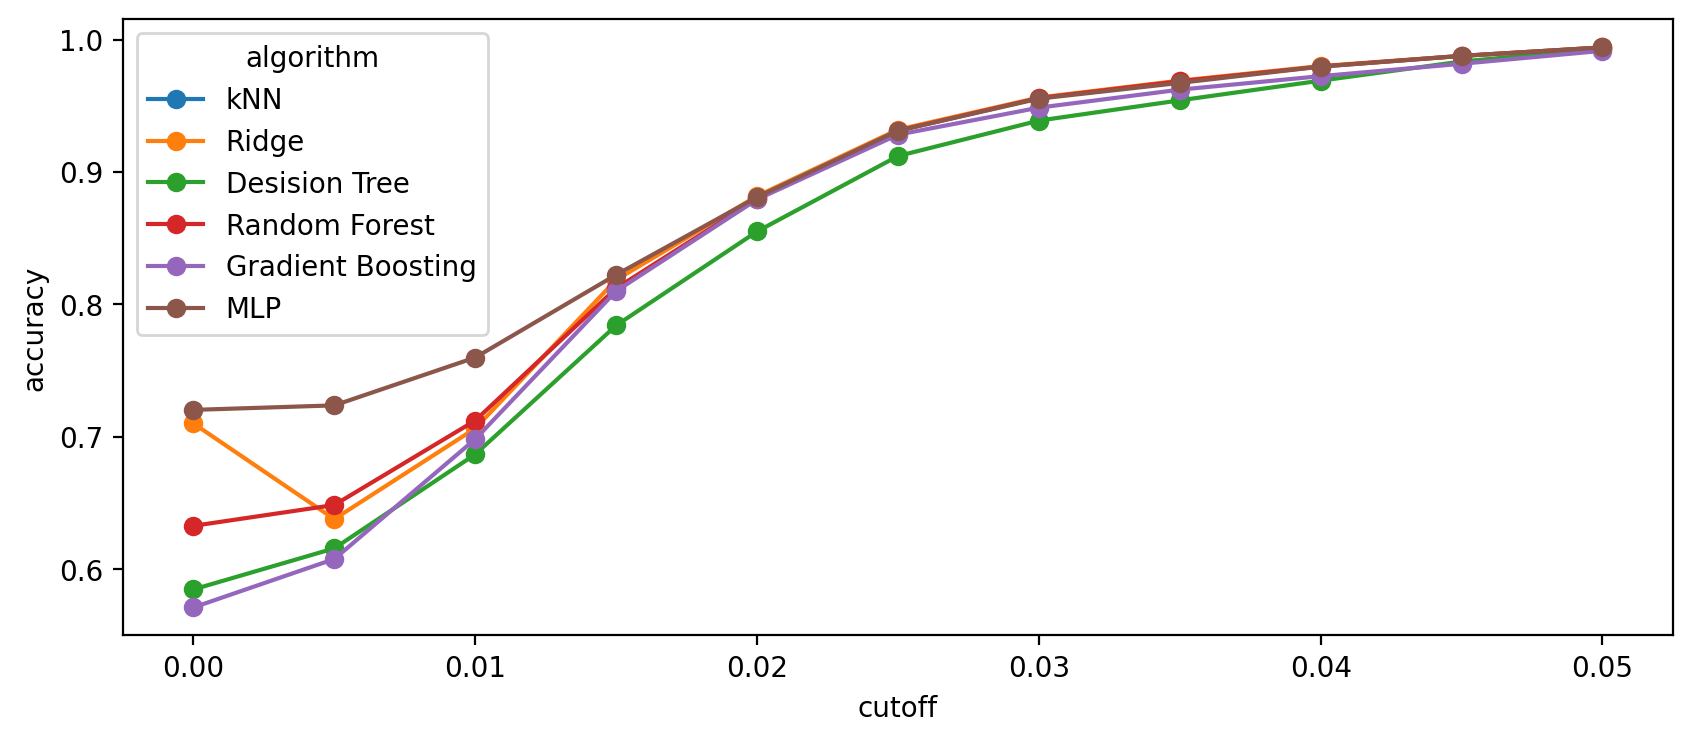

In [11]:
cut_list = [0.000, 0.005, 0.010, 0.015, 0.020, 0.025, 0.030, 0.035, 0.040, 0.045, 0.050]
train_cutoff = create_train_function('cutoff_arg', 10000)
results, tf_ratios = train_cutoff(cut_list)
print(tf_ratios)
np.save('cutoff_arg.npy', pd.DataFrame(results).reset_index())
plot_arg_train('cutoff_arg.npy', cut_list)

100%|██████████| 12/12 [29:02<00:00, 145.20s/it]


Label  False  True 
2       2338     14
3       1885     66
4       1761    132
5       1758    203
6       1774    254
7       1943    397
8       2136    464
9       1807    462
10      1480    407
11      1427    414
12      1465    454
13      1377    565


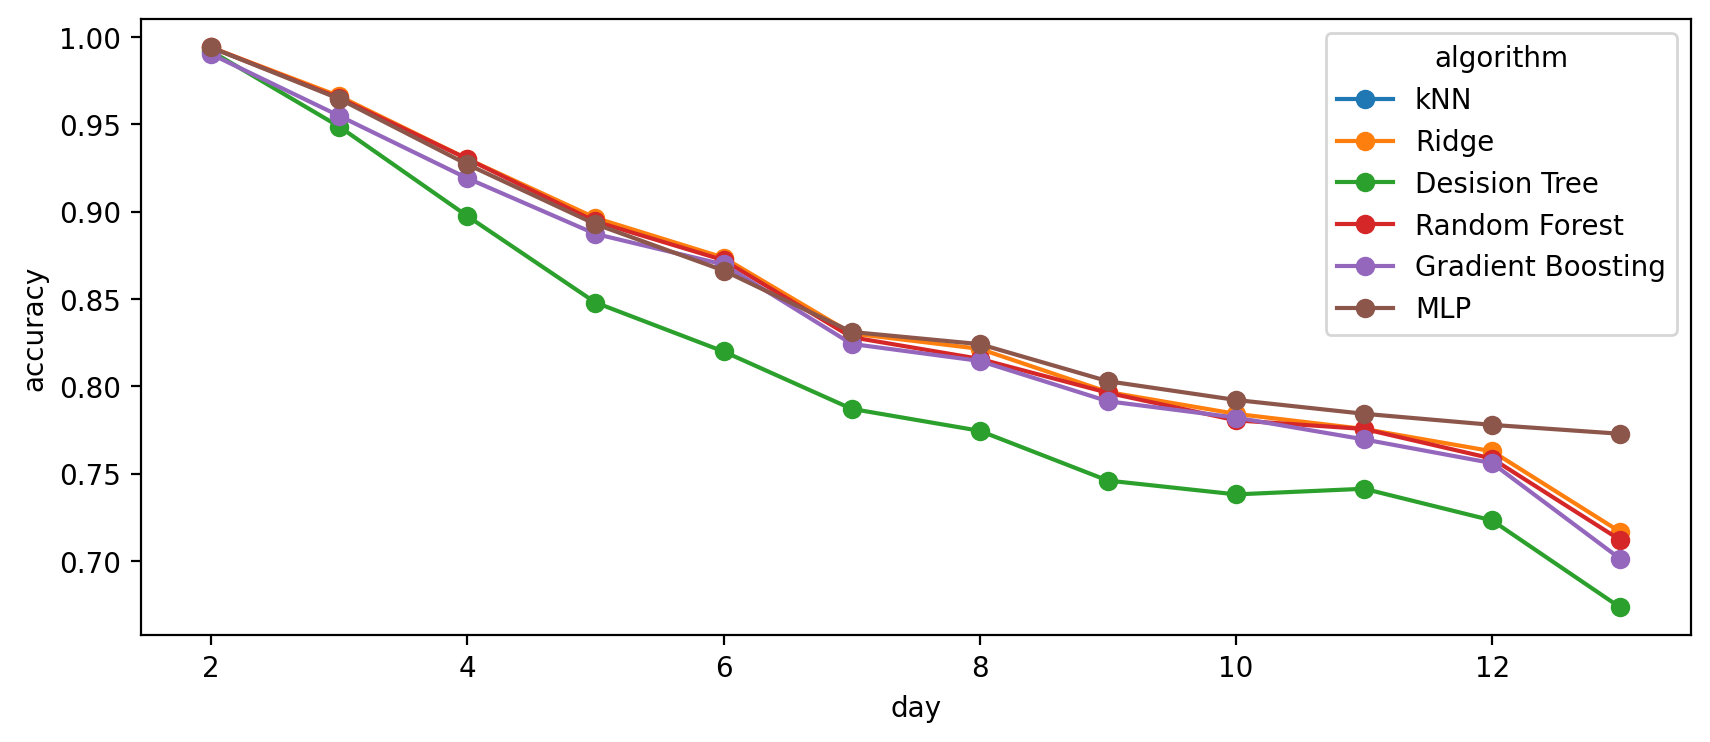

In [7]:
lag_list = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
train_lag = create_train_function('day_arg', 10000)
results, tf_ratios = train_lag(lag_list)
print(tf_ratios)
np.save('day_arg.npy', pd.DataFrame(results).reset_index())
plot_arg_train('day_arg.npy', lag_list)

100%|██████████| 8/8 [14:43<00:00, 110.49s/it]


Label  False  True 
500     1377    565
1000    1377    565
1500    1377    565
2000    1377    565
2500    1377    565
3000    1377    565
3500    1377    565
4000    1377    565


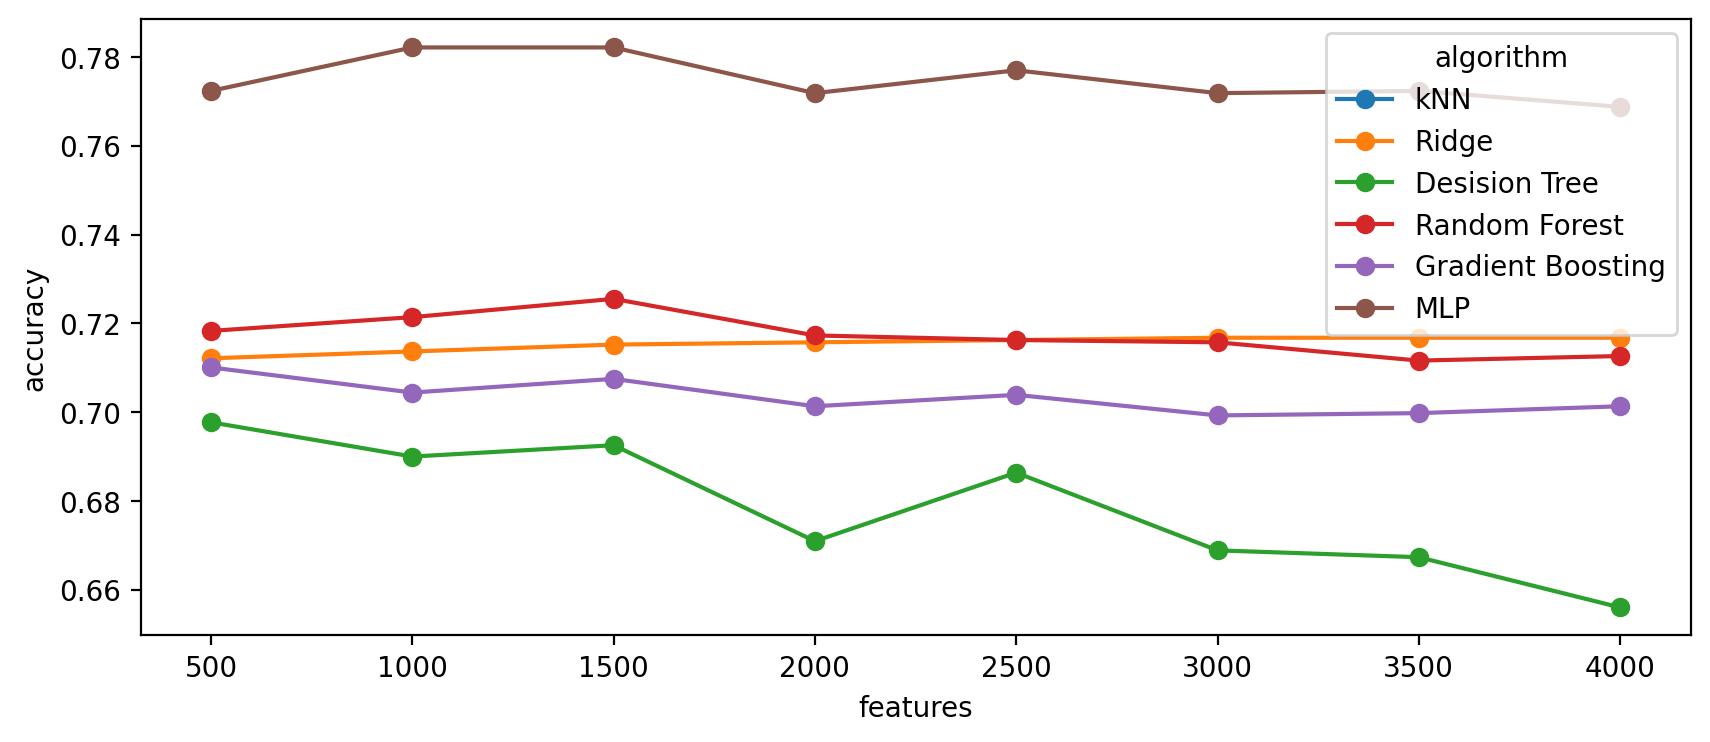

In [8]:
k_list = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000]
train_k_feature = create_train_function('features_num', 10000)
results, tf_ratios = train_k_feature(k_list)
print(tf_ratios)
np.save('features_num.npy', pd.DataFrame(results).reset_index())
plot_arg_train('features_num.npy', k_list)

# 4. Train & Test 1: 過去測試未來

In [2]:
from sklearn.neural_network import MLPClassifier
from etl_func.etl_data import transform_stock_df
from df_func.make_XY import Words_Matrix
from df_func.predict import Predict_Machine
from args import (
    word_df, stock_df, stop_words,
    day_arg, cutoff_arg, features_num
    )

train_words_matrix = Words_Matrix(
    word_df=word_df.sample(n=15000, random_state=42),
    stock_df=transform_stock_df(stock_df, D=day_arg, cutoff=cutoff_arg),
    data_time=(datetime.date(2019,1,1), datetime.date(2021,5,31)),
    stop_words=stop_words
    )

test_words_matrix = Words_Matrix(
    word_df=word_df.sample(n=15000, random_state=42),
    stock_df=transform_stock_df(stock_df, D=day_arg, cutoff=cutoff_arg),
    data_time=(datetime.date(2021,6,1), datetime.date(2021,12,31)),
    stop_words=stop_words
    )

MLPclf = MLPClassifier()

mlp_machine = Predict_Machine(
    train_words_matrix=train_words_matrix,
    test_words_matrix=test_words_matrix,
    features_num=features_num,
    classifier=MLPclf
    )

In [3]:
mlp_machine.YY_hat['Label_hat'].value_counts()

Label_hat
False    89
True     14
Name: count, dtype: int64

In [4]:
print('Confusion Matrix:\n', mlp_machine.show_confusion())
print()
print('Accuracy Score:', round(mlp_machine.show_accuracy(), 3))

Confusion Matrix:
           True  False
Positive    70     13
Negative    17      3

Accuracy Score: 0.699


# 5. Train & Test 2: 移動回測

In [5]:
from tqdm import trange
from sklearn.neural_network import MLPClassifier
from etl_func.etl_data import transform_stock_df
from df_func.make_XY import Words_Matrix
from df_func.predict import Predict_Machine, Date_Machine
from args import (
    word_df, stock_df, stop_words,
    day_arg, cutoff_arg, features_num,
    data_time
    )

result_matrix = pd.DataFrame(
            [[0, 0], [0, 0]],
            index=['Positive', 'Negative'],
            columns=['True', 'False'],
            )
result_accuracy = []
date_machine = Date_Machine(train_duration=5, test_duration=3, data_time=data_time)

for i in trange(29):
    date_machine.index = i

    train_words_matrix = Words_Matrix(
        word_df=word_df.sample(n=15000, random_state=42),
        stock_df=transform_stock_df(stock_df, D=day_arg, cutoff=cutoff_arg),
        data_time=date_machine.train_date,
        stop_words=stop_words
        )

    test_words_matrix = Words_Matrix(
    word_df=word_df.sample(n=15000, random_state=42),
        stock_df=transform_stock_df(stock_df, D=day_arg, cutoff=cutoff_arg),
        data_time=date_machine.test_date,
        stop_words=stop_words
        )

    MLPclf = MLPClassifier(alpha = 0.05)

    mlp_machine = Predict_Machine(
        train_words_matrix=train_words_matrix,
        test_words_matrix=test_words_matrix,
        features_num=features_num,
        classifier=MLPclf,
        )
    result_accuracy.append( round(mlp_machine.show_accuracy(), 3) )

    try:
        result_matrix += mlp_machine.show_confusion()
    except Exception as e:
        print(e)

print('Confusion Matrix in total:\n', result_matrix)

  0%|          | 0/29 [00:00<?, ?it/s]

100%|██████████| 29/29 [20:49<00:00, 43.10s/it]

Confusion Matrix in total:
           True  False
Positive   940     21
Negative   374     10


# 測試: why knn is nan?

In [47]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from df_func.train import train
from args import args_dict, args_class
from df_func.make_XY import Words_Matrix, feature_X_byChi2
from etl_func.etl_data import transform_stock_df
arg_name = 'cutoff_arg'
all_results = {}
for value_ in [0]:
    args_dict[arg_name] = value_
    args = args_class(args_dict)
    words_matrix = Words_Matrix(
        word_df=args.word_df.sample(n=2000, random_state=42),
        stock_df=transform_stock_df(
            args.stock_df, D=args.day_arg, cutoff=args.cutoff_arg
            ),
        data_time=args.data_time,
        stop_words=args.stop_words
        )
    X, Y = words_matrix.X_matrix, words_matrix.Y_matrix
    X = X[ feature_X_byChi2(X, Y, k=args.features_num) ]

    print(Y.value_counts().to_frame().T, end='\n\n')

    classifier_dict_={ 'kNN': KNeighborsClassifier }
    for classifier in classifier_dict_:
        clf = classifier_dict_[classifier]()
        scores = cross_val_score(estimator=clf, X=X , y=Y, cv=5)
        print(scores)

Label  True   False
count     47     34

[nan nan nan nan nan]
